In [1]:
# Make sure that you have all these libaries available to run the code successfully
#from pandas_datareader import data
#print("Importing...")
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.layers import Dense, Dropout 
import time
import pickle
import requests
import json
from pandas.io.json import json_normalize
import pprint
import pandas as pd

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected

In [2]:
def save_obj(obj, name ):
    with open('bin/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('bin/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
import numpy as np
import pandas as pd

def createDataframe(inFile, skip, dateField,priceField,separator):
    targetFile = open('datafile.csv','w') 
    file = open(inFile, 'r') 
    i=0
    for line in file: 
        i+=1
        if i>skip:
            targetFile.write(line)
    targetFile.close() 
    # Read in price field as string, and convert it later
    df = pd.read_csv('datafile.csv', sep=separator, converters={priceField: str})
    df = df.sort_values('Date', ascending=True).dropna()
    
    prices = df[[dateField,priceField]]
    # Replacing commas before typecasting 
    df[priceField].replace(',','.',inplace=True)
    # Typecasting
    df[priceField] = df[priceField].astype(float)
    # Renaming collumns
    df.rename(columns={dateField: 'Date', priceField:'Close'}, inplace=True)
    return df

#df = createDataframe('NOVO-B.CO.csv', 0,'Date','Close',',')

In [4]:

def createWindowedDataset(df, window_size, column='Close'):
    #from pandas import ordered_merge
    # Scale the data to be between 0 and 1
    # When scaling remember! You normalize both test and train data with respect to training data
    # Because you are not supposed to have access to test data
    print('Shape '+str(df.shape))
    # scale values
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled=scaler.fit_transform(df[[column]])
    series=pd.DataFrame(scaled)
    
    # Creating windowed dataset
    #print('Shape '+str(series.shape))
    series_s = series.copy()
    for i in range(window_size):
        prev = series_s.shift(-(i+1))
        prev.name = str(i)
        series = pd.concat([series, prev],axis=1)
    series.dropna(axis=0, inplace=True)
    newDF = series
    newDF.dropna(axis=0, inplace=True)
    return newDF, scaler
#createWindowedDataset(df,25)


In [5]:
def getTrainNumberOfRows(fraction, series):
    nrow = round(fraction*series.shape[0])
    return nrow
#nrow = getTestNumberOfRows(0.8,ds)
#nrow

In [6]:
def buildModel(window_size):
    model = Sequential()
    #model.add(LSTM(input_shape=(window_size,1), output_dim=window_size, return_sequences = True))
    model.add(LSTM(return_sequences=True, input_shape=(window_size, 1), units=50))
    model.add(Dropout(0.2))
    model.add(LSTM(256))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation("linear"))
    model.compile(loss="mse",optimizer="adam")
    model.summary
    return model

In [7]:
def trainModel(nrow, model, train_data_predictors, train_data_target, test_data_predictors, test_data_target):   
    start = time.time()
    model.fit(train_data_predictors,train_data_target,batch_size=512,epochs=20,validation_split=0.1, verbose=0)
    print("> Compilation Time : ", time.time() - start)
    return model
#trainedModel = trainModel(nrow, model, ds)




In [8]:

def downloadSymbolHistory(symbol, maxDate='2999-12-31', mode='persisted'):
    # Downloads historik data for symbol.
    # Filters rows newer than maxDate, so that historic data can be simmulated
    # and training the model as of any given historic date can be performed
    
    if mode.upper()!='DOWNLOAD':
        myDf=load_obj(symbol)
        print("Note: Loaded persisted time series data")
        return myDf[myDf.index<=maxDate]#.tail(1000)
    url = "https://www.alphavantage.co/query"
    function = "TIME_SERIES_DAILY"
    #symbol = "MSFT"
    api_key = "JS1OH18PC49XLGCG"   
    datatype = "json"
    outputsize = "full"

    data = { "function"   : function, 
             "symbol"     : symbol, 
             "apikey"     : api_key ,
             "datatype"   : datatype,
             "outputsize" : 'full'} 
    print("Note: Downloading time series data from "+url)
    page = requests.get(url, params = data)
    response_data = page.json()
    #print(response_data)
    try:
        timeSeriesJson = (response_data["Time Series (Daily)"])
    except:
        print("Error - retrying every 30 secs...")
        for i in range(1,5):
            try:
                time.sleep(30)
                print("Retrying...")
                page = requests.get(url, params = data)
                response_data = page.json()
                timeSeriesJson = (response_data["Time Series (Daily)"])
                print("Success")
                break
            except:
                pass
            if i == 5:
                print("Did not succeed after 5 retrys, exiting")
                exit(6)
        #print(timeSeriesJson)
    #print("Number of datarows downloaded: "+str(len(timeSeriesJson)))
    myDict = {}
    for key, value in timeSeriesJson.items():
        myDict[key] = value.get('4. close')
    myDf = pd.DataFrame.from_dict(myDict, orient='index')    
    myDf.columns = ['Close']
    myDf.index.name = 'Date'
    myDf.sort_index(inplace=True, ascending=True)
    df = pd.DataFrame()
    counter=0
    rel = []
    for index, row in myDf.iterrows():
        if counter==0:
            prev=float(row['Close'])
            #print(float(row['Close']))
        r=(float(row['Close'])-prev)/float(row['Close'])
        rel.append(r)
        counter+=1
        prev=float(row['Close'])
    #print(len(rel))
    se = pd.Series(rel)
    myDf['Relative'] = se.values
    save_obj(myDf,symbol)
    return myDf[myDf.index<=maxDate]#.tail(1000)
#downloadSymbolHistory('INTC', '2017-12-31', 'download')

In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
def prepareAndTrain(symbol,df, maxDate='2999-12-31', window_size=50, column='Close',plot=True):
    alphaVantageAipKey='JS1OH18PC49XLGCG'
    #window_size=50
    #trainNRows = getTrainNumberOfRows(0.8,ds)
    #symbols = ['GOOGL']
    
    
    # Create the windowd dataframe
    series, scaler = createWindowedDataset(df,window_size, column)
    trainNrows = getTrainNumberOfRows(0.97,series)
    # Define the model
    model=buildModel(window_size)    
    # Create the train and test-dataset
    # Use the first
    print('trainNrows: '+str(trainNrows))
    #print('DS shape '+str(df.shape))
    train = series.iloc[:trainNrows, :]
    test = series.iloc[trainNrows:,:]
    # Now, shuffle the train-set
    from sklearn.utils import shuffle
    train = shuffle(train)
    # train_X is all rows, all columns minus last, which is the target variable
    train_X = train.iloc[:,:-1].values
    # train_y is all rows, last column only, which is the target variable
    train_y = train.iloc[:,-1].values
    test_X = test.iloc[:,:-1].values
    test_y = test.iloc[:,-1].values
    print('**')
    train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
    test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)
    trainedModel = trainModel(trainNrows, model, train_X, train_y, test_X, test_y)
        
    from matplotlib import pyplot
    ac=np.asarray(test_y).reshape(-1,1)
    actuals = scaler.inverse_transform(ac)
    pd = trainedModel.predict(test_X)
    predicts=scaler.inverse_transform(pd)
    mape = mean_absolute_percentage_error(actuals,predicts)
    if plot==True:
        pyplot.plot(actuals)
        pyplot.plot(predicts)
        pyplot.show()
        import pandas as pd
        d = pd.DataFrame({'actuals':actuals.flatten('F'), 'predicts':predicts.flatten('F')})
        print("Mean Absolute Error: "+str(mean_absolute_error(actuals,predicts)))
        print("Mean Squared Error: "+str(mean_squared_error(actuals,predicts)))
        print("Mean Absolute Percentage Error: "+str(mape))
    #return df, trainedModel, scaler, mape
    return trainedModel, scaler, mape

#data, tm, sc = prepareAndTrain('GOOGL')


In [11]:
# Defining function to predict n future values.
# Returns list of n predictions as numpy array, and last prediction as float
#input = test_X[0]
nDays = 5
def predictNdays(nDays, trainedModel, scaler, inputSequence):
    preds_moving = []                                    # Use this to store the prediction made on each test window
    moving_test_window = [inputSequence]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    
    for i in range(nDays):
        #print(i)
        preds_one_step = trainedModel.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
    lastNDaysPredictions = moving_test_window[0][len(moving_test_window)-(nDays+2):]
    nthDayPrediction = lastNDaysPredictions[0].tolist()[0]
    lastDayPrediction = scaler.inverse_transform(nthDayPrediction)[0][0]
    return scaler.inverse_transform(lastNDaysPredictions), lastDayPrediction

#predictNdays(5, trainedModel, scaler, test_X[0])

Building the code that will run continously.
We´ll skip the test-part, because we´re now only predicting

In [12]:

def predict(symbol, window_size, predictDays, data, tm, sc, maxDate='2999-12-31', column='Close'):
    #data, tm, sc, mape = prepareAndTrain(symbol, maxDate, window_size,column, True)
    se,sc = createWindowedDataset(data,window_size, column)
    latestSequence=se[len(se)-1:].values
    latestSequence = latestSequence.reshape(latestSequence.shape[1],latestSequence.shape[0])[len(latestSequence):]
    nDays, nThDay = predictNdays(predictDays, tm, sc, latestSequence)
    sc.inverse_transform(latestSequence)
    nDays, nThDay
    return nDays, mape

In [13]:
# Gets the closing price for the following trading day
def getNextClose(symbol, date='2999-12-31', column='Close'):
    if date=='2999-12-31':
        print("Error: No date supplied - cannot get next closingprice")
    data = downloadSymbolHistory(symbol)
    data.insert(0, 'row_num', range(0,len(data)))  # here we insert the row count
    y = data.loc[date]['row_num']
    nextClose=data.loc[data['row_num'] == y+1]
    return pd.to_numeric(nextClose[column], errors='coerce').tolist()[0]
#getNextClose('NYSE:AXP', date='2017-12-12')
    

In [14]:
# Returns a list of valid tradingdays for the supplied symbol
def getTradingDays(symbol):
    data = downloadSymbolHistory(symbol)
    return data.index.tolist()
#getTradingDays('NYSE:AXP')

In [15]:
#getTradingDays('DWDP')
#getNextClose('DWDP', '2018-07-02')
#downloadSymbolHistory('DWDP')

Note: Downloading time series data from https://www.alphavantage.co/query
Note: Loaded persisted time series data
*****************************
Simmulating 21 days for MMM

12:07:09
***
Simmulating MMM at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (5917, 2)
trainNrows: 5691
**
> Compilation Time :  276.4148955345154


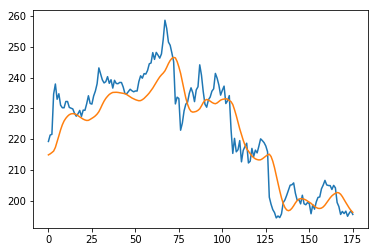

Mean Absolute Error: 5.5533045092496
Mean Squared Error: 49.901782848731045
Mean Absolute Percentage Error: 2.4681343595950938
Shape (5917, 2)
Note: Loaded persisted time series data
***
MMM:
MAPE             :2.4681343595950938
Latest close     : 195.52
Next close       : 195.71401111364364 (0.1%)
4 Days close     : 194.78263727903365 (-0.38%)
Actual next close: 195.83

12:11:47
***
Simmulating MMM at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
MMM:
MAPE             :2.4681343595950938
Latest close     : 195.83
Next close       : 195.34559348106384 (-0.25%)
4 Days close     : 194.5722333717346 (-0.64%)
Actual next close: 197.34

12:11:47
***
Simmulating MMM at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
MMM:
MAPE             :2.4681343595950938
Latest close     : 197.34
Next close       : 195.154327480793 (-1.11%)
4 Days close     : 194.6470

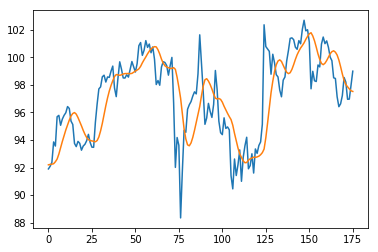

Mean Absolute Error: 1.6186126813021575
Mean Squared Error: 4.835297106985268
Mean Absolute Percentage Error: 1.6729562527329909
Shape (5917, 2)
Note: Loaded persisted time series data
***
AXP:
MAPE             :1.6729562527329909
Latest close     : 99.0
Next close       : 97.61376428045332 (-1.4%)
4 Days close     : 97.81713752962649 (-1.19%)
Actual next close: 97.84

12:16:29
***
Simmulating AXP at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
AXP:
MAPE             :1.6729562527329909
Latest close     : 97.84
Next close       : 97.70855632528664 (-0.13%)
4 Days close     : 97.90389545828104 (0.07%)
Actual next close: 98.53

12:16:29
***
Simmulating AXP at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
AXP:
MAPE             :1.6729562527329909
Latest close     : 98.53
Next close       : 97.84494943290949 (-0.7%)
4 Days close     : 98.092386137023

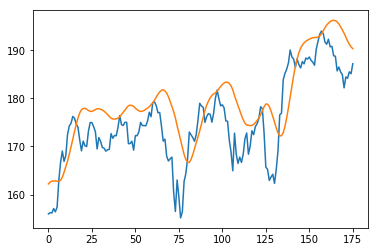

Mean Absolute Error: 5.715892295837403
Mean Squared Error: 48.707539154596816
Mean Absolute Percentage Error: 3.3252314169385766
Shape (5917, 2)
Note: Loaded persisted time series data
***
AAPL:
MAPE             :3.3252314169385766
Latest close     : 187.18
Next close       : 190.14113115251067 (1.58%)
4 Days close     : 191.18547628343106 (2.14%)
Actual next close: 183.92
Bying and selling - funds before: 9849.07
Bought and sold - funds now: 9648.5315

12:21:11
***
Simmulating AAPL at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
AAPL:
MAPE             :3.3252314169385766
Latest close     : 183.92
Next close       : 189.97455309271814 (3.29%)
4 Days close     : 190.97690712034705 (3.84%)
Actual next close: 185.4
Bying and selling - funds before: 9648.53
Bought and sold - funds now: 9697.173

12:21:11
***
Simmulating AAPL at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persis

Note: Loaded persisted time series data
*****************************
Simmulating 21 days for BA

12:21:16
***
Simmulating BA at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (5917, 2)
trainNrows: 5691
**
> Compilation Time :  276.9882810115814


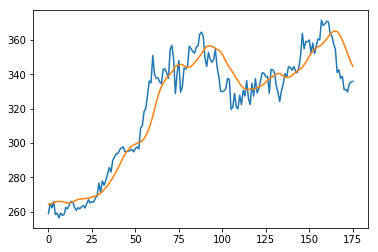

Mean Absolute Error: 8.059182510375974
Mean Squared Error: 109.566518515175
Mean Absolute Percentage Error: 2.4657244025977203
Shape (5917, 2)
Note: Loaded persisted time series data
***
BA:
MAPE             :2.4657244025977203
Latest close     : 336.08
Next close       : 343.215138656497 (2.12%)
4 Days close     : 341.71389205515385 (1.68%)
Actual next close: 332.93
Bying and selling - funds before: 10186.15
Bought and sold - funds now: 10061.6798

12:25:54
***
Simmulating BA at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
BA:
MAPE             :2.4657244025977203
Latest close     : 332.93
Next close       : 341.8855288898945 (2.69%)
4 Days close     : 340.7635438269377 (2.35%)
Actual next close: 333.18
Bying and selling - funds before: 10061.68
Bought and sold - funds now: 10040.2352

12:25:54
***
Simmulating BA at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time

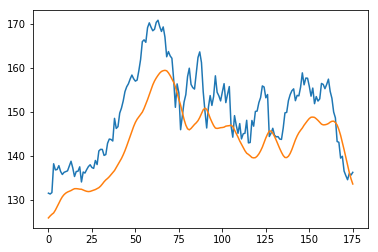

Mean Absolute Error: 7.2327852231805965
Mean Squared Error: 68.5667985153251
Mean Absolute Percentage Error: 4.741554502951114
Shape (5917, 2)
Note: Loaded persisted time series data
***
CAT:
MAPE             :4.741554502951114
Latest close     : 136.29
Next close       : 132.78062055587768 (-2.57%)
4 Days close     : 130.4737594592571 (-4.27%)
Actual next close: 133.83

12:30:36
***
Simmulating CAT at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
CAT:
MAPE             :4.741554502951114
Latest close     : 133.83
Next close       : 132.04653720140456 (-1.33%)
4 Days close     : 129.89507130146026 (-2.94%)
Actual next close: 135.81

12:30:36
***
Simmulating CAT at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
CAT:
MAPE             :4.741554502951114
Latest close     : 135.81
Next close       : 131.5489627611637 (-3.14%)
4 Days close     : 129.7402

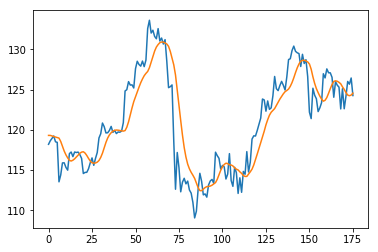

Mean Absolute Error: 2.1312449611317024
Mean Squared Error: 8.522030449847987
Mean Absolute Percentage Error: 1.7665498720673962
Shape (5917, 2)
Note: Loaded persisted time series data
***
CVX:
MAPE             :1.7665498720673962
Latest close     : 124.24999999999999
Next close       : 124.71760758161545 (0.38%)
4 Days close     : 124.8706162700057 (0.5%)
Actual next close: 124.73

12:35:18
***
Simmulating CVX at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
CVX:
MAPE             :1.7665498720673962
Latest close     : 124.73
Next close       : 124.82201136142015 (0.07%)
4 Days close     : 124.84911071062088 (0.1%)
Actual next close: 123.98

12:35:18
***
Simmulating CVX at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
CVX:
MAPE             :1.7665498720673962
Latest close     : 123.98
Next close       : 124.81024041384458 (0.67%)
4 Days close    

trainNrows: 5691
**
> Compilation Time :  275.0397026538849


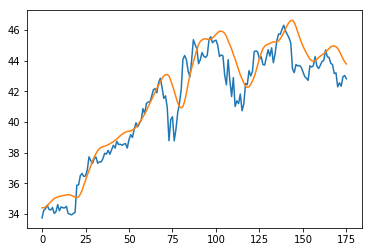

Mean Absolute Error: 0.9707929671894419
Mean Squared Error: 1.6190353116379044
Mean Absolute Percentage Error: 2.355007930802908
Shape (5917, 2)
Note: Loaded persisted time series data
***
CSCO:
MAPE             :2.355007930802908
Latest close     : 42.81
Next close       : 43.67918872833253 (2.03%)
4 Days close     : 43.849035698175435 (2.43%)
Actual next close: 42.67
Bying and selling - funds before: 10225.8
Bought and sold - funds now: 10163.3632

12:39:59
***
Simmulating CSCO at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
CSCO:
MAPE             :2.355007930802908
Latest close     : 42.67
Next close       : 43.60658883154393 (2.19%)
4 Days close     : 43.810312515497216 (2.67%)
Actual next close: 42.56
Bying and selling - funds before: 10163.36
Bought and sold - funds now: 10108.1629

12:40:00
***
Simmulating CSCO at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted

Note: Loaded persisted time series data
*****************************
Simmulating 21 days for KO

12:40:04
***
Simmulating KO at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (5917, 2)
trainNrows: 5691
**
> Compilation Time :  275.2979054450989


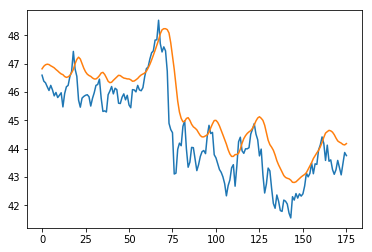

Mean Absolute Error: 0.8148166673833674
Mean Squared Error: 1.0627549389072295
Mean Absolute Percentage Error: 1.8481670217329635
Shape (5917, 2)
Note: Loaded persisted time series data
***
KO:
MAPE             :1.8481670217329635
Latest close     : 43.75
Next close       : 44.23898282557726 (1.12%)
4 Days close     : 44.651032679378986 (2.06%)
Actual next close: 43.99
Bying and selling - funds before: 10045.43
Bought and sold - funds now: 10071.5404

12:44:41
***
Simmulating KO at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
KO:
MAPE             :1.8481670217329635
Latest close     : 43.99
Next close       : 44.3288132250309 (0.77%)
4 Days close     : 44.756777273118495 (1.74%)
Actual next close: 44.66
Bying and selling - funds before: 10071.54
Bought and sold - funds now: 10195.9373

12:44:41
***
Simmulating KO at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time

Note: Loaded persisted time series data
*****************************
Simmulating 21 days for DIS

12:44:45
***
Simmulating DIS at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (5917, 2)
trainNrows: 5691
**
> Compilation Time :  275.34886717796326


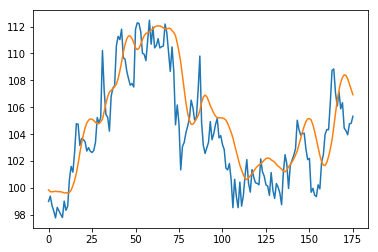

Mean Absolute Error: 1.934548551386053
Mean Squared Error: 5.833912251248619
Mean Absolute Percentage Error: 1.8630004200196952
Shape (5917, 2)
Note: Loaded persisted time series data
***
DIS:
MAPE             :1.8630004200196952
Latest close     : 105.33
Next close       : 106.6370549571514 (1.24%)
4 Days close     : 106.5970079728961 (1.2%)
Actual next close: 104.04
Bying and selling - funds before: 10360.27
Bought and sold - funds now: 10204.389

12:49:23
***
Simmulating DIS at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
DIS:
MAPE             :1.8630004200196952
Latest close     : 104.04
Next close       : 106.34267567902803 (2.21%)
4 Days close     : 106.29567442804574 (2.17%)
Actual next close: 105.34
Bying and selling - funds before: 10204.39
Bought and sold - funds now: 10302.8948

12:49:23
***
Simmulating DIS at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted

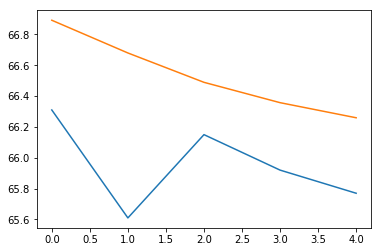

Mean Absolute Error: 0.5834537963867177
Mean Squared Error: 0.40565041730971946
Mean Absolute Percentage Error: 0.8855696650386529
Shape (213, 2)
Note: Loaded persisted time series data
***
DWDP:
MAPE             :0.8855696650386529
Latest close     : 65.77
Next close       : 66.17878178060054 (0.62%)
4 Days close     : 66.12484304606915 (0.54%)
Actual next close: 65.15
Bying and selling - funds before: 10572.0
Bought and sold - funds now: 10443.344

12:49:41
***
Simmulating DWDP at date: 2018-07-03
Note: Loaded persisted time series data
Shape (214, 2)
Note: Loaded persisted time series data
***
DWDP:
MAPE             :0.8855696650386529
Latest close     : 65.15
Next close       : 66.07320414096117 (1.42%)
4 Days close     : 65.97650058835745 (1.27%)
Actual next close: 66.07
Bying and selling - funds before: 10443.34
Bought and sold - funds now: 10561.8172

12:49:41
***
Simmulating DWDP at date: 2018-07-05
Note: Loaded persisted time series data
Shape (215, 2)
Note: Loaded persisted t

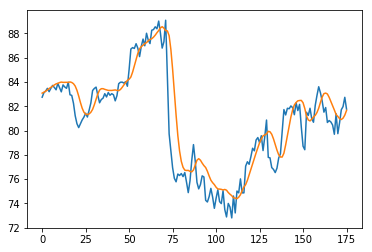

Mean Absolute Error: 1.2138083718039767
Mean Squared Error: 3.319968290090141
Mean Absolute Percentage Error: 1.5316772662134275
Shape (5917, 2)
Note: Loaded persisted time series data
***
XOM:
MAPE             :1.5316772662134275
Latest close     : 81.76
Next close       : 81.97136594176291 (0.26%)
4 Days close     : 82.59968351840972 (1.03%)
Actual next close: 82.24

12:54:23
***
Simmulating XOM at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
XOM:
MAPE             :1.5316772662134275
Latest close     : 82.24
Next close       : 82.25464326560497 (0.02%)
4 Days close     : 82.8134068262577 (0.7%)
Actual next close: 82.31

12:54:23
***
Simmulating XOM at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
XOM:
MAPE             :1.5316772662134275
Latest close     : 82.30999999999999
Next close       : 82.48421041488646 (0.21%)
4 Days close     : 82.963

Note: Loaded persisted time series data
*****************************
Simmulating 21 days for GS

12:54:27
***
Simmulating GS at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (4823, 2)
trainNrows: 4630
**
> Compilation Time :  225.74147510528564


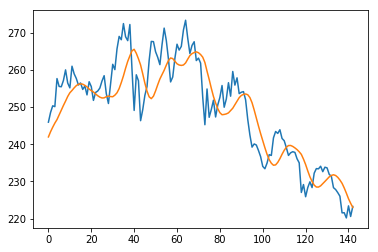

Mean Absolute Error: 5.278080525431596
Mean Squared Error: 42.538390807648014
Mean Absolute Percentage Error: 2.1026190341895012
Shape (4823, 2)
Note: Loaded persisted time series data
***
GS:
MAPE             :2.1026190341895012
Latest close     : 223.26
Next close       : 222.21414851844307 (-0.47%)
4 Days close     : 220.99148741543289 (-1.02%)
Actual next close: 220.38

12:58:15
***
Simmulating GS at date: 2018-07-03
Note: Loaded persisted time series data
Shape (4824, 2)
Note: Loaded persisted time series data
***
GS:
MAPE             :2.1026190341895012
Latest close     : 220.38
Next close       : 221.53783782899376 (0.53%)
4 Days close     : 220.43708128571507 (0.03%)
Actual next close: 220.74
Bying and selling - funds before: 10510.71
Bought and sold - funds now: 10498.881

12:58:15
***
Simmulating GS at date: 2018-07-05
Note: Loaded persisted time series data
Shape (4825, 2)
Note: Loaded persisted time series data
***
GS:
MAPE             :2.1026190341895012
Latest close     :

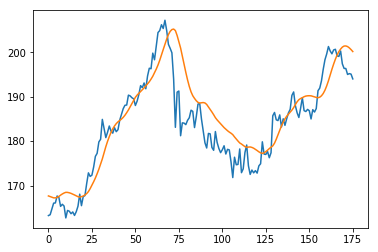

Mean Absolute Error: 4.019771163246848
Mean Squared Error: 27.27945703700735
Mean Absolute Percentage Error: 2.1900740995263552
Shape (5917, 2)
Note: Loaded persisted time series data
***
HD:
MAPE             :2.1900740995263552
Latest close     : 194.01999999999998
Next close       : 199.70257894665002 (2.93%)
4 Days close     : 199.43991953849792 (2.79%)
Actual next close: 193.62
Bying and selling - funds before: 10498.88
Bought and sold - funds now: 10448.2361

13:02:58
***
Simmulating HD at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
HD:
MAPE             :2.1900740995263552
Latest close     : 193.62
Next close       : 199.19561668157576 (2.88%)
4 Days close     : 198.9143582239747 (2.73%)
Actual next close: 194.41
Bying and selling - funds before: 10448.24
Bought and sold - funds now: 10461.8665

13:02:58
***
Simmulating HD at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loade

Note: Loaded persisted time series data
*****************************
Simmulating 21 days for IBM

13:03:03
***
Simmulating IBM at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (5917, 2)
trainNrows: 5691
**
> Compilation Time :  275.71936106681824


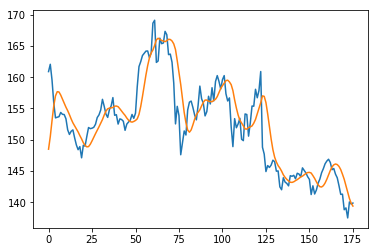

Mean Absolute Error: 2.6560825972123583
Mean Squared Error: 13.148767179911873
Mean Absolute Percentage Error: 1.7395924796445459
Shape (5917, 2)
Note: Loaded persisted time series data
***
IBM:
MAPE             :1.7395924796445459
Latest close     : 139.86
Next close       : 139.14537749804558 (-0.51%)
4 Days close     : 138.92223797507583 (-0.67%)
Actual next close: 139.57

13:07:41
***
Simmulating IBM at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
IBM:
MAPE             :1.7395924796445459
Latest close     : 139.57
Next close       : 139.06383185215293 (-0.36%)
4 Days close     : 138.9992670585215 (-0.41%)
Actual next close: 141.43

13:07:41
***
Simmulating IBM at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
IBM:
MAPE             :1.7395924796445459
Latest close     : 141.43
Next close       : 139.25831005223097 (-1.54%)
4 Days close     : 1

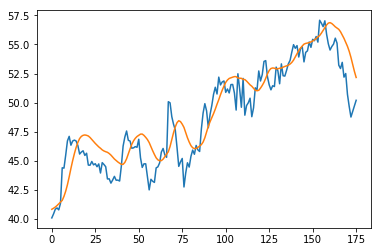

Mean Absolute Error: 1.5046712129766286
Mean Squared Error: 3.55479706238996
Mean Absolute Percentage Error: 3.152294473667793
Shape (5917, 2)
Note: Loaded persisted time series data
***
INTC:
MAPE             :3.152294473667793
Latest close     : 50.2
Next close       : 51.75508776545525 (3.1%)
4 Days close     : 51.51298762083054 (2.62%)
Actual next close: 49.47
Bying and selling - funds before: 10322.62
Bought and sold - funds now: 10143.5065

13:12:24
***
Simmulating INTC at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
INTC:
MAPE             :3.152294473667793
Latest close     : 49.47
Next close       : 51.41375080108643 (3.93%)
4 Days close     : 51.256395318508154 (3.61%)
Actual next close: 50.75
Bying and selling - funds before: 10143.51
Bought and sold - funds now: 10376.9623

13:12:24
***
Simmulating INTC at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted tim

Note: Loaded persisted time series data
*****************************
Simmulating 21 days for JNJ

13:12:30
***
Simmulating JNJ at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (5917, 2)
trainNrows: 5691
**
> Compilation Time :  276.37736201286316


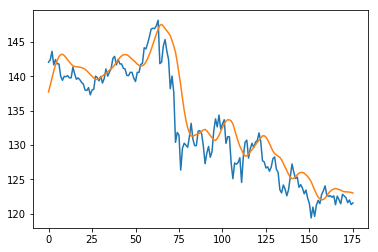

Mean Absolute Error: 2.324547191966664
Mean Squared Error: 9.789226729644765
Mean Absolute Percentage Error: 1.7644025179500238
Shape (5917, 2)
Note: Loaded persisted time series data
***
JNJ:
MAPE             :1.7644025179500238
Latest close     : 121.58000000000001
Next close       : 122.9178160661459 (1.1%)
4 Days close     : 123.09762042045594 (1.25%)
Actual next close: 122.71
Bying and selling - funds before: 9766.22
Bought and sold - funds now: 9827.9862

13:17:08
***
Simmulating JNJ at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
JNJ:
MAPE             :1.7644025179500238
Latest close     : 122.70999999999998
Next close       : 122.89605087608099 (0.15%)
4 Days close     : 123.21586390972138 (0.41%)
Actual next close: 125.0

13:17:08
***
Simmulating JNJ at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
JNJ:
MAPE             :1.7644025179500

trainNrows: 5691
**
> Compilation Time :  276.09988260269165


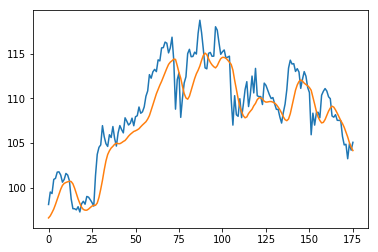

Mean Absolute Error: 1.970204608223655
Mean Squared Error: 6.146172692977128
Mean Absolute Percentage Error: 1.7999937291964978
Shape (5917, 2)
Note: Loaded persisted time series data
***
JPM:
MAPE             :1.7999937291964978
Latest close     : 105.08
Next close       : 103.94641795232893 (-1.08%)
4 Days close     : 103.44490816667677 (-1.56%)
Actual next close: 103.61

13:21:52
***
Simmulating JPM at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
JPM:
MAPE             :1.7999937291964978
Latest close     : 103.61
Next close       : 103.74017832577229 (0.13%)
4 Days close     : 103.20430539697409 (-0.39%)
Actual next close: 103.72

13:21:52
***
Simmulating JPM at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
JPM:
MAPE             :1.7999937291964978
Latest close     : 103.72
Next close       : 103.55270023047925 (-0.16%)
4 Days close     : 103

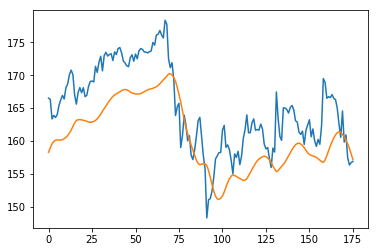

Mean Absolute Error: 4.983937485434793
Mean Squared Error: 31.89653661587239
Mean Absolute Percentage Error: 2.9931728903538755
Shape (5917, 2)
Note: Loaded persisted time series data
***
MCD:
MAPE             :2.9931728903538755
Latest close     : 156.87
Next close       : 156.32854839742186 (-0.35%)
4 Days close     : 154.2162260824442 (-1.69%)
Actual next close: 156.48

13:32:51
***
Simmulating MCD at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
MCD:
MAPE             :2.9931728903538755
Latest close     : 156.48
Next close       : 155.57950119376184 (-0.58%)
4 Days close     : 153.61354846119883 (-1.83%)
Actual next close: 157.32

13:32:51
***
Simmulating MCD at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
MCD:
MAPE             :2.9931728903538755
Latest close     : 157.32
Next close       : 154.96727665483954 (-1.5%)
4 Days close     : 153.

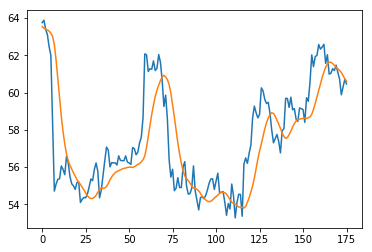

Mean Absolute Error: 1.2964878411726521
Mean Squared Error: 3.4147812900255716
Mean Absolute Percentage Error: 2.2449885089344814
Shape (5917, 2)
Note: Loaded persisted time series data
***
MRK:
MAPE             :2.2449885089344814
Latest close     : 60.46
Next close       : 60.48792819976807 (0.05%)
4 Days close     : 60.244128949046136 (-0.36%)
Actual next close: 60.71

13:50:24
***
Simmulating MRK at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
MRK:
MAPE             :2.2449885089344814
Latest close     : 60.71
Next close       : 60.40774546295405 (-0.5%)
4 Days close     : 60.21434966668487 (-0.82%)
Actual next close: 61.64

13:50:24
***
Simmulating MRK at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
MRK:
MAPE             :2.2449885089344814
Latest close     : 61.64
Next close       : 60.41663753077388 (-1.98%)
4 Days close     : 60.34808209

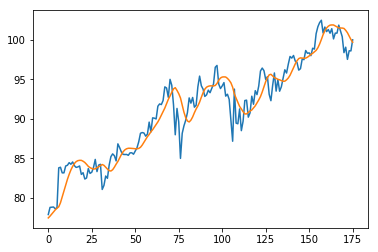

Mean Absolute Error: 1.4271215681596232
Mean Squared Error: 3.5561302228252654
Mean Absolute Percentage Error: 1.5742316082043597
Shape (5917, 2)
Note: Loaded persisted time series data
***
MSFT:
MAPE             :1.5742316082043597
Latest close     : 100.01
Next close       : 99.53021780110896 (-0.48%)
4 Days close     : 99.54527776502073 (-0.46%)
Actual next close: 99.05

14:08:28
***
Simmulating MSFT at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
MSFT:
MAPE             :1.5742316082043597
Latest close     : 99.05
Next close       : 99.43374581599608 (0.39%)
4 Days close     : 99.53586006950587 (0.49%)
Actual next close: 99.76

14:08:28
***
Simmulating MSFT at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
MSFT:
MAPE             :1.5742316082043597
Latest close     : 99.76
Next close       : 99.44606199592351 (-0.31%)
4 Days close     : 99.692

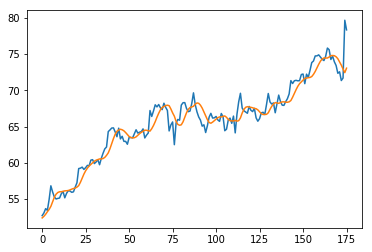

Mean Absolute Error: 1.0333949853723696
Mean Squared Error: 2.079112505366079
Mean Absolute Percentage Error: 1.5505749627557928
Shape (5917, 2)
Note: Loaded persisted time series data
***
NKE:
MAPE             :1.5505749627557928
Latest close     : 78.35
Next close       : 74.12100925005971 (-5.4%)
4 Days close     : 75.3147427939996 (-3.87%)
Actual next close: 76.28

14:25:35
***
Simmulating NKE at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
NKE:
MAPE             :1.5505749627557928
Latest close     : 76.28
Next close       : 75.04272773724048 (-1.62%)
4 Days close     : 75.96827990476041 (-0.41%)
Actual next close: 76.55

14:25:36
***
Simmulating NKE at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
NKE:
MAPE             :1.5505749627557928
Latest close     : 76.55
Next close       : 75.76718532469123 (-1.02%)
4 Days close     : 76.4005290692

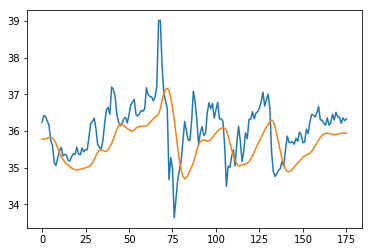

Mean Absolute Error: 0.6707505148107359
Mean Squared Error: 0.684381762317864
Mean Absolute Percentage Error: 1.8569238667974595
Shape (5917, 2)
Note: Loaded persisted time series data
***
PFE:
MAPE             :1.8569238667974595
Latest close     : 36.33
Next close       : 35.93587214827537 (-1.08%)
4 Days close     : 35.817770164012906 (-1.41%)
Actual next close: 36.35

14:44:27
***
Simmulating PFE at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
PFE:
MAPE             :1.8569238667974595
Latest close     : 36.35
Next close       : 35.93467153072356 (-1.14%)
4 Days close     : 35.81960203409194 (-1.46%)
Actual next close: 36.87

14:44:28
***
Simmulating PFE at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
PFE:
MAPE             :1.8569238667974595
Latest close     : 36.87
Next close       : 35.96461270451545 (-2.46%)
4 Days close     : 35.8985663

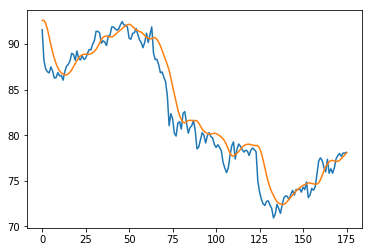

Mean Absolute Error: 1.2570015335083002
Mean Squared Error: 3.0615002494106576
Mean Absolute Percentage Error: 1.5518901129677498
Shape (5917, 2)
Note: Loaded persisted time series data
***
PG:
MAPE             :1.5518901129677498
Latest close     : 78.13
Next close       : 78.24589571297167 (0.15%)
4 Days close     : 78.69592185556888 (0.72%)
Actual next close: 77.9

15:00:45
***
Simmulating PG at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
PG:
MAPE             :1.5518901129677498
Latest close     : 77.9
Next close       : 78.38365492820739 (0.62%)
4 Days close     : 78.75722093522548 (1.1%)
Actual next close: 79.21
Bying and selling - funds before: 10543.65
Bought and sold - funds now: 10691.9556

15:00:45
***
Simmulating PG at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
PG:
MAPE             :1.5518901129677498
Latest close     : 79.21
Next

trainNrows: 5691
**
> Compilation Time :  1158.8535423278809


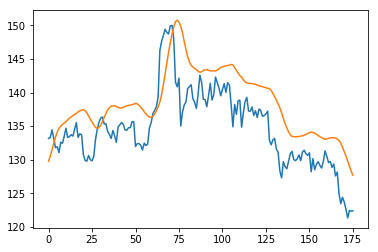

Mean Absolute Error: 4.30935828295621
Mean Squared Error: 24.330398383296288
Mean Absolute Percentage Error: 3.2218551094603747
Shape (5917, 2)
Note: Loaded persisted time series data
***
TRV:
MAPE             :3.2218551094603747
Latest close     : 122.39
Next close       : 127.16802527010441 (3.9%)
4 Days close     : 127.47192042320967 (4.15%)
Actual next close: 122.77
Bying and selling - funds before: 10947.52
Bought and sold - funds now: 10952.5053

15:20:12
***
Simmulating TRV at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
TRV:
MAPE             :3.2218551094603747
Latest close     : 122.77
Next close       : 126.77235270291567 (3.26%)
4 Days close     : 127.25377897918224 (3.65%)
Actual next close: 122.6
Bying and selling - funds before: 10952.51
Bought and sold - funds now: 10908.3393

15:20:12
***
Simmulating TRV at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persist

Note: Loaded persisted time series data
*****************************
Simmulating 21 days for UTX

15:20:17
***
Simmulating UTX at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (5917, 2)
trainNrows: 5691
**
> Compilation Time :  1015.6281385421753


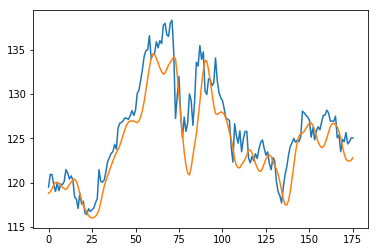

Mean Absolute Error: 2.0777324884588078
Mean Squared Error: 7.34094369758985
Mean Absolute Percentage Error: 1.6275493912109145
Shape (5917, 2)
Note: Loaded persisted time series data
***
UTX:
MAPE             :1.6275493912109145
Latest close     : 125.03
Next close       : 123.12448456764221 (-1.52%)
4 Days close     : 122.75905105590822 (-1.82%)
Actual next close: 124.92

15:37:21
***
Simmulating UTX at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
UTX:
MAPE             :1.6275493912109145
Latest close     : 124.92000000000002
Next close       : 123.44536130905152 (-1.18%)
4 Days close     : 123.04618357658387 (-1.5%)
Actual next close: 124.95

15:37:21
***
Simmulating UTX at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
UTX:
MAPE             :1.6275493912109145
Latest close     : 124.95
Next close       : 123.7107154083252 (-0.99%)
4 Days clos

In [ ]:
#nDays, nThDay = predictNdays(nDays, tm, sc)
import time
#############################
# Setup                     #
#############################
sleepSecs = 600
results = {}
funds=10000
trainOnce=True
symbols = ['MMM','AXP','AAPL','BA','CAT','CVX','CSCO','KO','DIS','DWDP','XOM','GS','HD','IBM','INTC','JNJ','JPM','MCD','MRK','MSFT','NKE','PFE','PG','TRV','UTX','UNH','VZ','V','WMT','WBA']
#symbols = ['JNJ','JPM','MCD','MRK','MSFT','NKE','PFE','PG','TRV','UTX','UNH','VZ','V','WMT','WBA']
#symbols = ['BA']
column='Close'
window_size=50
symbolGains = {}

#############################
for symbol in symbols:
    downloadSymbolHistory(symbol,'2999-12-31','download')
    days = [days for days in getTradingDays(symbol) if days >= '2018-07-01' and days < '2018-08-01']
    print("*****************************")
    print("Simmulating "+str(len(days))+" days for "+symbol)
    #tradingDays=getTradingDays(symbol)
    dayNumber=0
    for day in days:
        startFunds=funds
        dayNumber+=1
        print("")
        print (time.strftime("%H:%M:%S"))
        print("***")
        print("Simmulating "+symbol+" at date: "+day)
        #break
        data=downloadSymbolHistory(symbol, day)
        if dayNumber==1:
            print("Training...")
            tm, sc, mape = prepareAndTrain(symbol, data, day, window_size,column, True)
        else:
            if trainOnce==False:
                print("Training...")
                tm, sc, mape = prepareAndTrain(symbol,data, day, window_size,column, True)
        nDays, mape = predict(symbol,window_size,5, data, tm, sc, day, column) #Close vs Relative
        latestClose=nDays[0][0]
        nextClose=nDays[1][0]
        fourDaysClose=nDays[4][0]
        actualNextClose=getNextClose(symbol, day, column)
        gainPct = round((nextClose-latestClose)/latestClose*100,2)    
        fourDaysGainPct = round((fourDaysClose-latestClose)/latestClose*100,2)        
        print("***")
        print(symbol+":")
        print("MAPE             :"+str(mape))        
        if column == 'Close':
            print("Latest close     : "+str(latestClose))
            print("Next close       : "+str(nextClose)+" ("+str(gainPct)+"%)")
            print("4 Days close     : "+str(fourDaysClose)+" ("+str(fourDaysGainPct)+"%)")
            print("Actual next close: "+str(actualNextClose))
            if gainPct>0.50:
                print("Bying and selling - funds before: "+str(round(funds,2)))
                funds=(funds/latestClose*actualNextClose)-29
                print("Bought and sold - funds now: "+str(round(funds,4)))
        if column == 'Relative':
            print("Latest close     : "+str(round(latestClose*100,4))+'%')
            print("Next close       : "+str(round(nextClose*100,4))+"%")
            print("4 Days close     : "+str(round(fourDaysClose*100,4))+"%")
            print("Actual next close: "+str(round(actualNextClose*100,4))+"%")
            if nextClose>0.005:
                print("Bying and selling - funds before: "+str(round(funds,2)))
                funds=(funds*(actualNextClose+1))-29
                print("Bought and sold - funds now: "+str(round(funds,2)))
        results[symbol]=[nDays,[mape]]
    print("Funds total: "+str(round(funds,2)))
    symbolGains[symbol]=str(round((funds-startFunds)/funds*100,4))+'%'
    print(symbolGains)
    
    #print("Sleeping before next symbol")
    #time.sleep(sleepSecs)
    
    
    

In [ ]:
for key, value in results.items():
    nDays=value[0]
    mape = value[1]
    #print(mape[0])
    print(key+":")
    print("Mean Percentage Absolute Error: "+str(round(mape[0],2))+"%")
    print("Latest close                  : "+str(nDays[0][0]))
    print("Next close                    : "+str(nDays[1][0])+" ("+str(round((nDays[1][0]-nDays[0][0])/nDays[0][0]*100,2))+"%)")
    print("Close in "+str(len(nDays)-1)+" days               : "+str(nDays[5][0])+" ("+str(round((nDays[5][0]-nDays[0][0])/nDays[0][0]*100,2))+"%)")
    print('***')